# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 4D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$.
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j, \\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 4  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1.2=

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the true Moreau envelope S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = min_x { 0.5*||x-y||_2^2 + ||x||_1 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    term1 = 0.5 * euclid_norm_sq(prox_y - y_points) # sum of squares of differences, then sum over components
    term2 = np.sum(np.abs(prox_y), axis=1) # L1 norm for each vector y_j
    s_values = term1 + term2
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points, y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points, y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")


Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# # --- Generate Training Data (using Moreau envelope target as per notebook) ---
# # Sample y_j points (uniformly on [-a, a]^n grid)
# y_j_41= np.zeros((dim_41,data_points_41))

# if(dim_41>1):
#     for k in range(0,dim_41):
#         y_j_41[k] = np.random.uniform(-a_41,a_41,data_points_41)
# else:
#     y_j_41 = np.random.uniform(-a_41,a_41,data_points_41)

# #y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
# y_j_41 = y_j_41.reshape(data_points_41,dim_41)


# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")


Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l2.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 29.42829132080078
iteration 500 loss 3.492398500442505
iteration 0 loss 3.0183045864105225
iteration 500 loss 2.798492670059204
iteration 1000 loss 2.5452561378479004
iteration 1500 loss 2.1943273544311523
iteration 2000 loss 1.6382533311843872
iteration 2500 loss 0.809432327747345
iteration 3000 loss 0.2928556501865387
iteration 3500 loss 0.19026491045951843
iteration 4000 loss 0.15092916786670685
iteration 4500 loss 0.1255120486021042
iteration 5000 loss 0.1059601828455925
iteration 5500 loss 0.08890799432992935
iteration 6000 loss 0.07448796182870865
iteration 6500 loss 0.06121496111154556
iteration 7000 loss 0.04979187250137329
iteration 7500 loss 0.04057958349585533
iteration 8000 loss 0.033126551657915115
iteration 8500 loss 0.027417797595262527
iteration 9000 loss 0.022756878286600113
iteration 9500 loss 0.018779844045639038
iteration 10000 loss 0.014791510067880154
iteration 10500 loss 0.011493684723973274
ite

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=4) ---
loss -2.943769931793213
loss -53.4415283203125
loss -102.3857192993164
loss -147.13522338867188
loss -179.93060302734375
loss -200.53750610351562
loss -214.9822998046875
loss -225.62307739257812
loss -233.36868286132812
loss -238.7935333251953
loss -242.5295867919922
loss -245.2884521484375
loss -247.57528686523438
loss -249.60394287109375
loss -251.36062622070312
loss -252.71127319335938
loss -253.56382751464844
loss -253.98330688476562
loss -254.1416473388672
loss -254.1893310546875
loss -254.20216369628906
loss -254.2056427001953
loss -254.20660400390625
loss -254.20681762695312
loss -254.2068634033203
loss -254.20687866210938
loss -254.2068634033203
loss -254.2068634033203
loss -254.2068634033203
loss -254.2068634033203
loss -254.20689392089844
loss -254.20687866210938
loss -254.20689392089844
loss -254.2068634033203
loss -254.20687866210938
loss -254.2068634033203
loss -254.2068634033203
loss -254.2068634033203
los

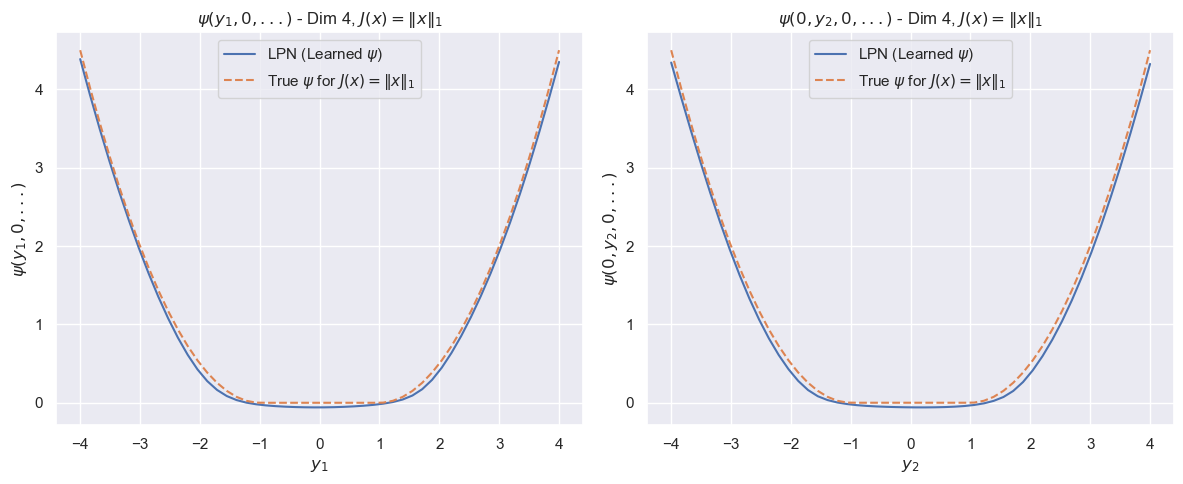

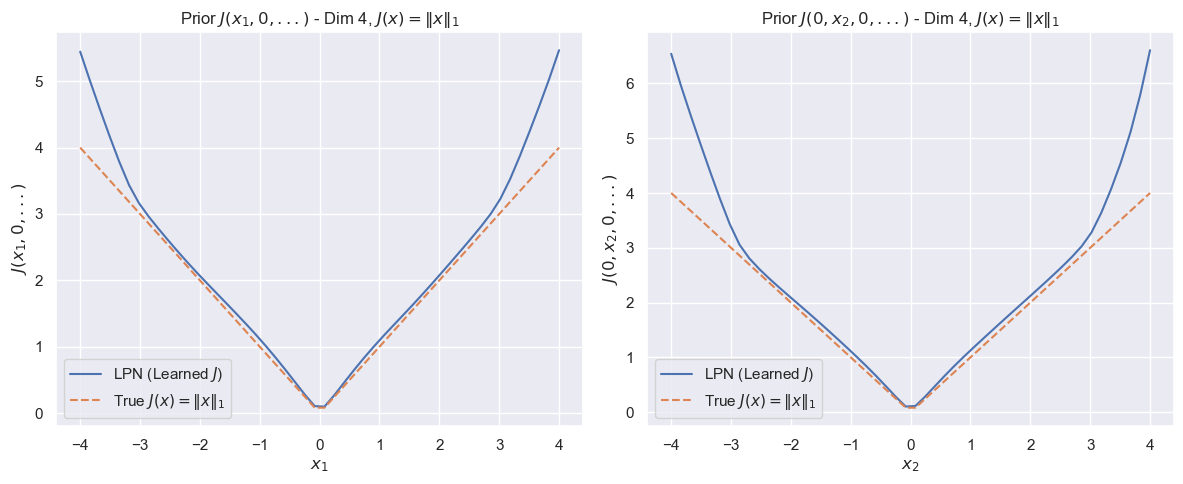

In [8]:
# L2 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


L1 loss -- Train

In [9]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 4.445788860321045
iteration 500 loss 1.336364507675171
iteration 0 loss 1.2672370672225952
iteration 500 loss 1.16077721118927
iteration 1000 loss 0.964531421661377
iteration 1500 loss 0.5038126707077026
iteration 2000 loss 0.2819913923740387
iteration 2500 loss 0.21844276785850525
iteration 3000 loss 0.17318610846996307
iteration 3500 loss 0.14963200688362122
iteration 4000 loss 0.13332869112491608
iteration 4500 loss 0.12036752700805664
iteration 5000 loss 0.10974002629518509
iteration 5500 loss 0.10155821591615677
iteration 6000 loss 0.09506622701883316
iteration 6500 loss 0.08973297476768494
iteration 7000 loss 0.0851348489522934
iteration 7500 loss 0.0811818316578865
iteration 8000 loss 0.07766883820295334
iteration 8500 loss 0.07440675050020218
iteration 9000 loss 0.07145761698484421
iteration 9500 loss 0.06897041946649551
iteration 10000 loss 0.06667256355285645
iteration 10500 loss 0.06463026255369186
iteratio

L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=4) ---
loss -3.6291122436523438
loss -53.85193634033203
loss -102.38753509521484
loss -146.461181640625
loss -181.40235900878906
loss -204.63925170898438
loss -219.07537841796875
loss -228.88970947265625
loss -236.2578887939453
loss -241.8842315673828
loss -246.0515899658203
loss -249.14547729492188
loss -251.58157348632812
loss -253.6166534423828
loss -255.3166961669922
loss -256.6468811035156
loss -257.5856628417969
loss -258.1731262207031
loss -258.49517822265625
loss -258.6463623046875
loss -258.7040710449219
loss -258.72052001953125
loss -258.7237243652344
loss -258.72406005859375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.72412109375
loss -258.7241210

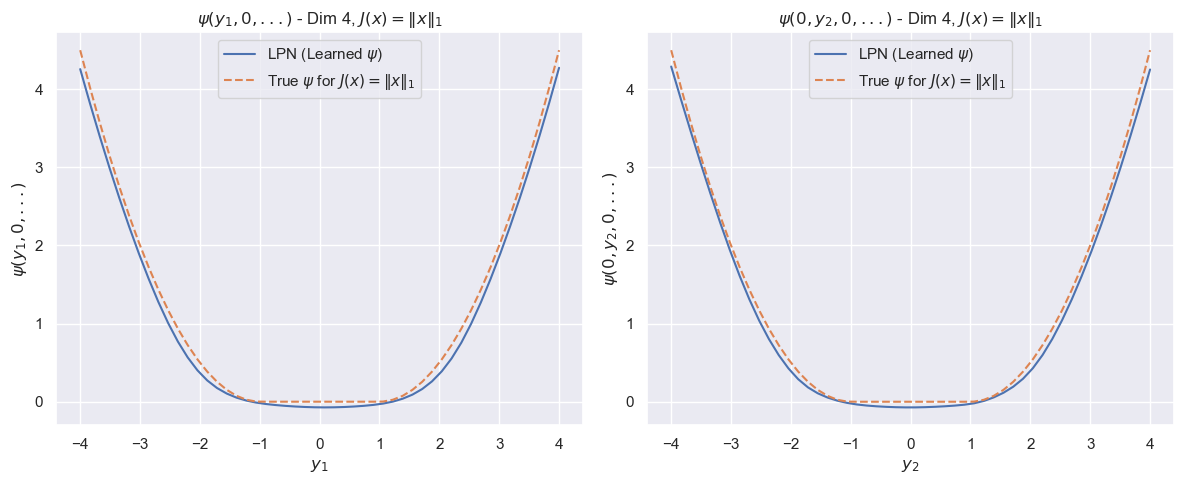

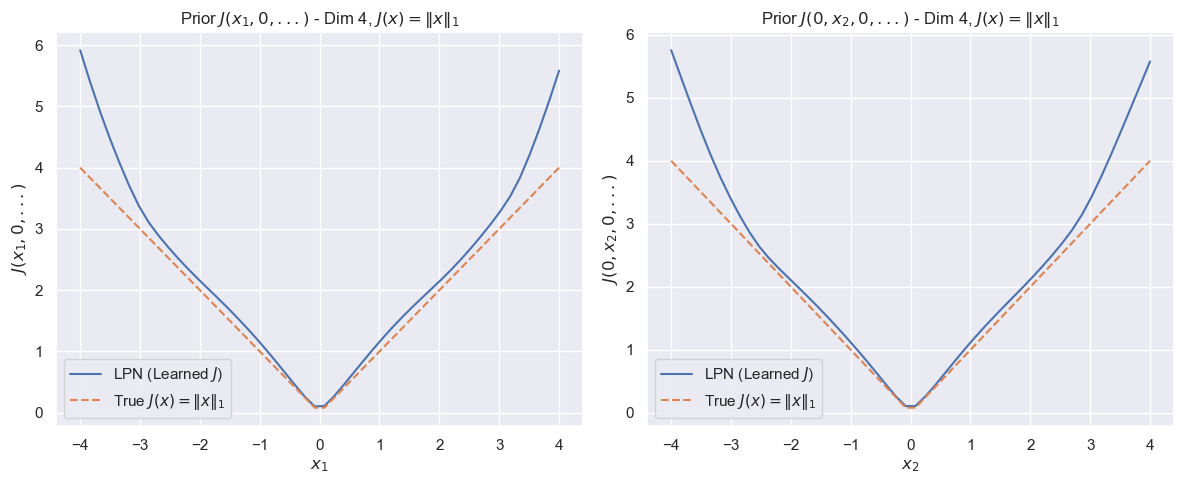

In [10]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [11]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [12]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [13]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [14]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [15]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [16]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)